## Examining the Relationship Between Economic Instability of Several Countries and BitCoin Market Capitalization

### Authors: Achal Srinivasan and Corrin Fosmire

### Section 1: Setting up Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import time
import datetime as dt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,7)

/home/infrared/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
#using IMF API, acquire information for a particular country
def generate_data(country_abbr="US", metric="PXP_IX", resolution="M", start=2009, end=2017):
    data = requests.get("http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/"+resolution+"."+country_abbr+"."+metric+".?startPeriod="+str(start)+"&endPeriod="+str(end)).json()
    df = pd.DataFrame(data['CompactData']['DataSet']['Series']['Obs'])
    df = df.rename(index=str, columns={"@OBS_VALUE" : country_abbr+"."+metric, "@TIME_PERIOD" : "date"})
    return df

In [3]:
#loading economic health data for certain countries"

countries = ["US", "TR", "UY", "VE"]
#United States, Turkey, Uruguay, and Venezuela

metrics = ["PCPI_IX", "ENDE_XDC_USD_RATE", "LE_IX"]
#consumer price index (should indicate inflation), exchange rate (in domestic currency), employment index

print(generate_data(country_abbr="VE",metric="LE_IX").head())

           VE.LE_IX     date
0  95.2845153189527  2009-01
1  96.6061907446666  2009-02
2  98.9964787569285  2009-03
3  100.581520598223  2009-04
4  99.1473978082267  2009-05


In [4]:
def make_dataset(countries, metrics):
    #make first table, so then we can do joins on the rest
    empty = True
    full_data = None
    
    for country in countries:
        for metric in metrics:
            if empty:
                full_data = generate_data(country_abbr=country, metric=metric)
                empty = False
            else:
                metric_data = generate_data(country_abbr=country, metric=metric)
                full_data = full_data.merge(metric_data, on="date")
        time.sleep(5) #avoid throttling
                

    return full_data

In [5]:
financial_data = make_dataset(countries, metrics)

In [6]:
#so we have contiguous time data with no gaps
financial_data = financial_data[financial_data.index > 24]

#deleting status variables we don't really care about
financial_data = financial_data[list(filter(lambda a: not a[0] == "@", list(financial_data.columns.values)))]

In [7]:
financial_data["date"] = financial_data["date"]+"-01"

In [8]:
#loading bitcoin data
btc_data = pd.read_csv("btc.csv")
btc_data = btc_data[btc_data["marketcap(USD)"] != np.nan]

#selecting columns of interest
mc_date = btc_data[["date","marketcap(USD)"]]

#converting to date time format
mc_date['date'] = pd.to_datetime(mc_date['date'])
mc_date = mc_date.dropna()

years = [2013,2014,2015,2016]

mc_date = mc_date[mc_date['date'].dt.year.isin(years) & mc_date['date'].dt.day.isin([1])]
mc_date['date'] = mc_date['date'].dt.strftime(date_format="%Y-%m-%d")
mc_date.head()

/home/infrared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,date,marketcap(USD)
1573,2013-05-01,1.543334e+09
1604,2013-06-01,1.446526e+09
1634,2013-07-01,1.107511e+09
1665,2013-08-01,1.220624e+09
1696,2013-09-01,1.572969e+09


In [10]:
combined = mc_date.merge(financial_data, on="date")
combined['date'] = pd.to_datetime(combined['date'])
combined.head()

,date,marketcap(USD),US.PCPI_IX,US.ENDE_XDC_USD_RATE,US.LE_IX,TR.PCPI_IX,TR.ENDE_XDC_USD_RATE,TR.LE_IX,UY.PCPI_IX,UY.ENDE_XDC_USD_RATE,UY.LE_IX,VE.PCPI_IX,VE.ENDE_XDC_USD_RATE,VE.LE_IX
0,2013-05-01,1.543334e+09,106.82830747218,1,103.860155432124,123.357623318386,1.8678,115.555129702857,125.21024235677,20.268,109.694540116312,201.233371509118,6.2842,104.516678174481
1,2013-06-01,1.446526e+09,107.084664225392,1,104.154264795505,124.29932735426,1.9289,116.390947518159,125.754902800377,20.547,109.423522104907,210.695092943353,6.2842,107.427463520202
2,2013-07-01,1.107511e+09,107.126855318944,1,104.34985830856,124.686098654709,1.92585,115.418037891882,126.720904341869,21.5,107.323132516515,217.408157871553,6.2842,107.460299917853
3,2013-08-01,1.220624e+09,107.255721593814,1,103.91552565457,124.557174887892,2.05755,114.803335900734,128.03631069624,22.589,109.423522104907,223.962646462867,6.2842,108.142678440948
4,2013-09-01,1.572969e+09,107.380460479098,1,104.017636973886,125.510089686099,2.036,114.131143795306,129.783334760641,22.038,109.220258596353,233.794379349837,6.2842,108.270747894389


In [20]:
for country in countries:
    for metric in metrics:
        combined[country+"."+metric] = pd.to_numeric(combined[country+"."+metric])

### Section 2: Exploratory Data Analysis

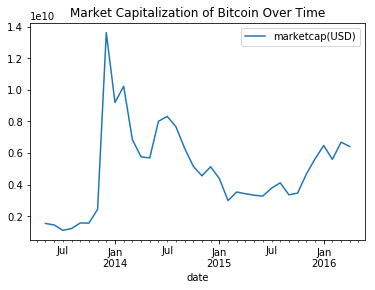

In [16]:
combined.plot(x='date',y='marketcap(USD)', title="Market Capitalization of Bitcoin Over Time")

#### We note that the market cap of BitCoin skyrocketed at the end of 2013, then gradually declined until 2015, where it rebounded again.

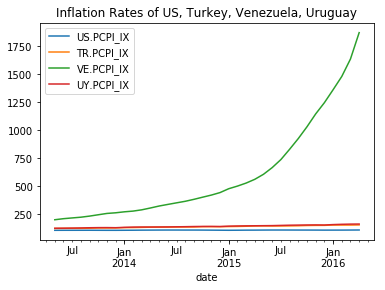

In [26]:
ax = combined.plot(x='date',y='US.PCPI_IX')
combined.plot(x='date',y='TR.PCPI_IX', ax=ax)
combined.plot(x='date',y='VE.PCPI_IX', ax=ax)
combined.plot(x='date',y='UY.PCPI_IX', ax=ax, title="Inflation Rates of US, Turkey, Venezuela, Uruguay")

#### Clearly, Venezuela's inflation rate is far, far greater than the other countries, and has been increasing more and more quickly with time.

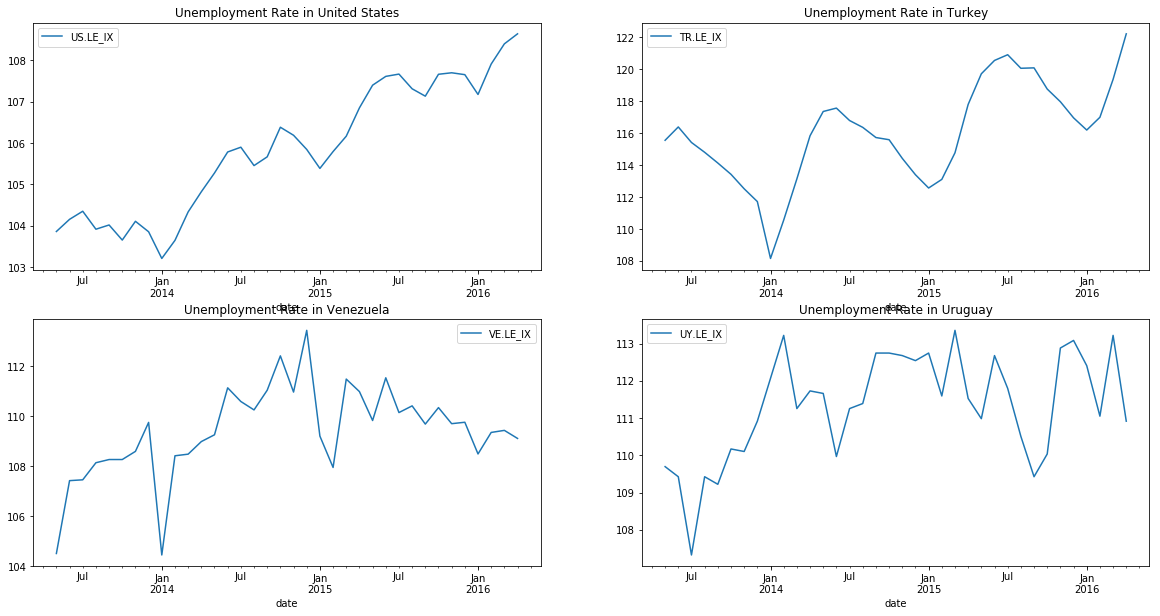

In [31]:
plt.rcParams['figure.figsize'] = (20,10)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

combined.plot(x='date',y='US.LE_IX', ax=ax1, title="Unemployment Rate in United States")
combined.plot(x='date',y='TR.LE_IX', ax=ax2, title="Unemployment Rate in Turkey")
combined.plot(x='date',y='VE.LE_IX', ax=ax3, title="Unemployment Rate in Venezuela")
combined.plot(x='date',y='UY.LE_IX', ax=ax4, title="Unemployment Rate in Uruguay")

#### Three of the countries had notably low unemployment rates in January 2014. Turkey seems to have a high degree of cyclical unemployment, and the United States and Turkey both have an upward trend. Venezuela and Uruguay have less of a trend but more volatility.

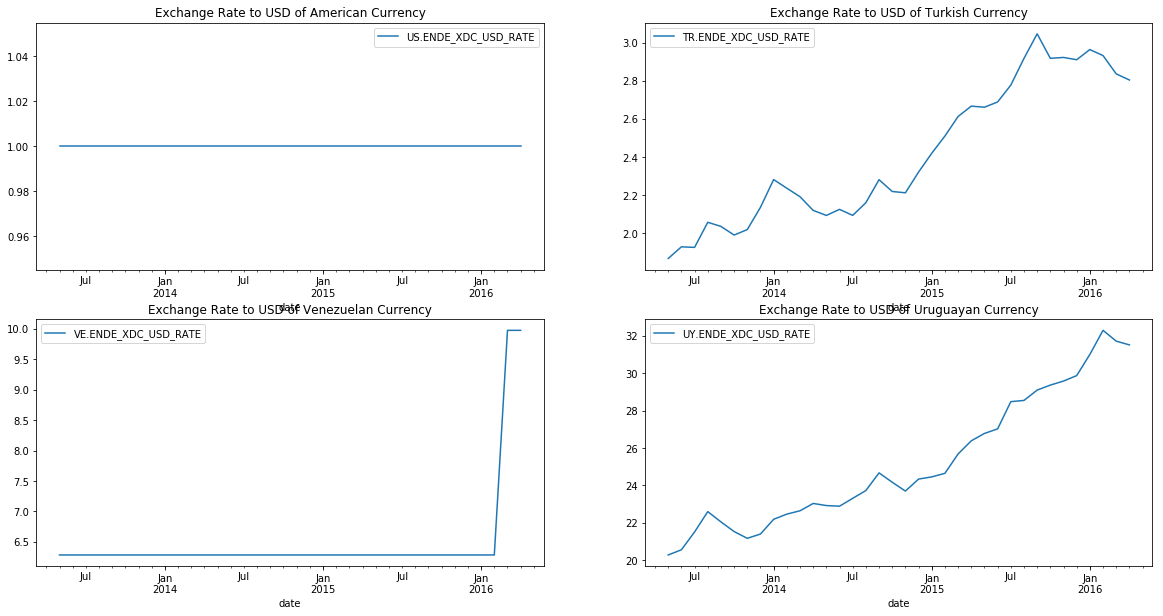

In [32]:
plt.rcParams['figure.figsize'] = (20,10)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

combined.plot(x='date',y='US.ENDE_XDC_USD_RATE', ax=ax1, title="Exchange Rate to USD of American Currency")
combined.plot(x='date',y='TR.ENDE_XDC_USD_RATE', ax=ax2, title="Exchange Rate to USD of Turkish Currency")
combined.plot(x='date',y='VE.ENDE_XDC_USD_RATE', ax=ax3, title="Exchange Rate to USD of Venezuelan Currency")
combined.plot(x='date',y='UY.ENDE_XDC_USD_RATE', ax=ax4, title="Exchange Rate to USD of Uruguayan Currency")

#### Clearly, the exchange rate in USD of USD is 1, which explains the line of the American currency. All three other currencies have been devalued relative to the USD steadily from 2013 to 2016, with the price of Venezuela markedly exploding in value after 2016, almost doubling in value.

### Section 3: Modeling

#### We will build models with and without exogenous regressors to predict BitCoin market cap, using both SARIMAX and Facebook Prophet models.

### Section 4: Data Visualization